Dense Neural Network for cattle weight gain

INSTITUTO FEDERAL DE MINAS GERIAS Departamento de Engenharia e Computação

Professor: Ciniro Nametala

Aluno: Euler Gomes e Daniel Reis

# 1. Ambient preparation

In [206]:
from IPython.display import display, HTML

display(HTML("<style>.container {widht: 100% !important;}</style>"))

## 1.1. Import packages

In [207]:
import subprocess
import sys
import os

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import progressbar
import pygame

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torchinfo import summary

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 1.2. Export requirements

In [208]:
def export_requirements():
    try:
        result = subprocess.run([sys.executable, "-m", "pip", "freeze"],
                                capture_output=True,
                                text=True,
                                check=True)
        with open('requirements.txt', 'w') as f:
            f.write(result.stdout)
        print('requirements.txt file generated successfully.')
    except subprocess.CalledProcessError as e:
        print('error:', e)


export_requirements()

requirements.txt file generated successfully.


## 1.3. GPU check

In [209]:
if torch.cuda.is_available():
    print("__CUDNN VERSION:", torch.backends.cudnn.version())
    print("Device Name:", torch.cuda.get_device_name(0))
    device = 'cuda'
else:
    print("CUDA is not available.")
    device = 'cpu'

print('Device:', device)

__CUDNN VERSION: 91200
Device Name: NVIDIA GeForce RTX 5070
Device: cuda


## 1.4. Experiment configuration

In [210]:
new_model: True

save_model: True

# 2. Load dataset

In [211]:
data = pd.read_csv('data/cattle_gain.csv')

target = "saida_gmd_kg_dia"
col_names = data.columns.values.tolist()

print(col_names)
data.head()

['sexo', 'raca', 'idade_dias', 'peso_inicial_kg', 'qualidade_pasto', 'tipo_pasto', 'taxa_lotacao_ua_ha', 'area_pasto_ha_animal', 'quantidade_suplemento_kg_dia', 'suplementacao_acesso_livre', 'evento_sanitario_recente', 'tipo_evento_sanitario', 'vermifugacao_recente', 'vacina_recente', 'tratamento_recente', 'temperatura_media', 'estacao_ano', 'rotacao_piquete', 'condicao_corporal', 'tipo_suplementato', 'frequencia_suplementacao_semana', 'facilidade_acesso_agua', 'severidade_evento', 'estresse_transporte', 'estresse_manejo', 'dias_evento_sanitario', 'tipo_sistema_manejo', 'dias_permanecia', 'tipo_fonte_agua', 'saida_ganho_total_kg', 'saida_gmd_kg_dia']


,sexo,raca,idade_dias,peso_inicial_kg,qualidade_pasto,tipo_pasto,taxa_lotacao_ua_ha,area_pasto_ha_animal,quantidade_suplemento_kg_dia,suplementacao_acesso_livre,...,facilidade_acesso_agua,severidade_evento,estresse_transporte,estresse_manejo,dias_evento_sanitario,tipo_sistema_manejo,dias_permanecia,tipo_fonte_agua,saida_ganho_total_kg,saida_gmd_kg_dia
0,F,anelorada,620,185,media,decumbens_tanzania_mg4_marandu,1,0.857143,0.248,sim,...,muito_facil,nao,sim,nao,nao,piquete_rotacionado,381,poco_artesiano,126,0.330709
1,F,anelorada,620,168,media,decumbens_tanzania_mg4_marandu,1,0.857143,0.248,sim,...,muito_facil,nao,sim,nao,nao,piquete_rotacionado,450,poco_artesiano,148,0.328889
2,F,anelorada,620,153,media,decumbens_tanzania_mg4_marandu,1,0.857143,0.248,sim,...,muito_facil,nao,sim,nao,nao,piquete_rotacionado,450,poco_artesiano,143,0.317778
3,F,anelorada,620,130,media,decumbens_tanzania_mg4_marandu,1,0.857143,0.248,sim,...,muito_facil,nao,sim,nao,nao,piquete_rotacionado,450,poco_artesiano,211,0.468889
4,F,anelorada,620,156,media,decumbens_tanzania_mg4_marandu,1,0.857143,0.248,sim,...,muito_facil,nao,sim,nao,nao,piquete_rotacionado,450,poco_artesiano,154,0.342222


## 2.1. Separate x and y from data

In [212]:
cols_to_drop = [
    "saida_ganho_total_kg",  # se existir
]
data = data.drop(columns=[c for c in cols_to_drop if c in data.columns])

x = data.drop(columns=target)
y = data[target]

print(y.head())

0    0.330709
1    0.328889
2    0.317778
3    0.468889
4    0.342222
Name: saida_gmd_kg_dia, dtype: float64


## 2.2. Data exploration

In [213]:
data.describe()

,idade_dias,peso_inicial_kg,taxa_lotacao_ua_ha,area_pasto_ha_animal,quantidade_suplemento_kg_dia,temperatura_media,frequencia_suplementacao_semana,dias_permanecia,saida_gmd_kg_dia
count,203.000000,203.000000,203.0,203.000000,203.000000,203.000000,203.0,203.000000,203.000000
mean,547.990148,176.704433,1.0,1.090429,0.875961,26.359606,7.0,379.300493,0.309417
std,79.147374,49.263801,0.0,0.217470,0.226504,4.026367,0.0,178.012774,0.131877
min,384.000000,25.000000,1.0,0.857143,0.248000,20.000000,7.0,43.000000,-0.186047
25%,530.000000,140.000000,1.0,0.900000,0.784500,23.000000,7.0,271.500000,0.255967
50%,530.000000,177.000000,1.0,0.900000,0.915000,24.000000,7.0,375.000000,0.334204
75%,530.000000,208.000000,1.0,1.333333,1.047000,31.000000,7.0,465.000000,0.387532
max,890.000000,306.000000,1.0,1.333333,1.623000,31.000000,7.0,933.000000,0.610390


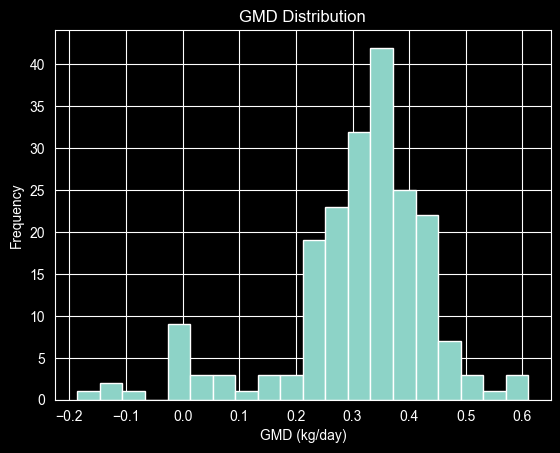

In [214]:
plt.hist(data["saida_gmd_kg_dia"], bins=20)
plt.xlabel("GMD (kg/day)")
plt.ylabel("Frequency")
plt.title("GMD Distribution")
plt.show()

## 2.3. Checking for missing values

In [215]:
data.isna().sum().sort_values(ascending=False)

sexo                               0
raca                               0
idade_dias                         0
peso_inicial_kg                    0
qualidade_pasto                    0
tipo_pasto                         0
taxa_lotacao_ua_ha                 0
area_pasto_ha_animal               0
quantidade_suplemento_kg_dia       0
suplementacao_acesso_livre         0
evento_sanitario_recente           0
tipo_evento_sanitario              0
vermifugacao_recente               0
vacina_recente                     0
tratamento_recente                 0
temperatura_media                  0
estacao_ano                        0
rotacao_piquete                    0
condicao_corporal                  0
tipo_suplementato                  0
frequencia_suplementacao_semana    0
facilidade_acesso_agua             0
severidade_evento                  0
estresse_transporte                0
estresse_manejo                    0
dias_evento_sanitario              0
tipo_sistema_manejo                0
d

# 3. Pre-processing

## 3.1. One-Hot Encoding

In [216]:
x = pd.get_dummies(x, drop_first=True)

x.dtypes

idade_dias                                     int64
peso_inicial_kg                                int64
taxa_lotacao_ua_ha                             int64
area_pasto_ha_animal                         float64
quantidade_suplemento_kg_dia                 float64
temperatura_media                              int64
frequencia_suplementacao_semana                int64
dias_permanecia                                int64
raca_angus                                      bool
raca_girolando                                  bool
raca_guzera                                     bool
raca_holandesa                                  bool
raca_nelore                                     bool
qualidade_pasto_media                           bool
tipo_pasto_marandu_braquiaria_mg5_estrela       bool
evento_sanitario_recente_sim                    bool
tipo_evento_sanitario_nao                       bool
tratamento_recente_sim                          bool
estacao_ano_outono                            

## 3.2. Split dataset

In [217]:
x_train, x_temp, y_train, y_temp = train_test_split(
    x, y, test_size=0.26, random_state=42
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.50, random_state=42
)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(150, 30)
(150,)
(26, 30)
(26,)
(27, 30)
(27,)


## 3.3. Data normalization

In [218]:
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

## 3.4. To Tensor

In [219]:
x_train_t = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)

x_val_t = torch.tensor(x_val, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1).to(device)

x_test_t = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

x_train_t

tensor([[ 0.9317,  0.2945,  0.0000,  ...,  4.2131, -0.0819,  0.1162],
        [-0.2418, -0.0640,  0.0000,  ..., -0.2374, -0.0819,  0.1162],
        [-0.2418, -1.2153,  0.0000,  ..., -0.2374, -0.0819,  0.1162],
        ...,
        [-0.2418,  0.2945,  0.0000,  ..., -0.2374, -0.0819,  0.1162],
        [-0.2418, -0.5359,  0.0000,  ..., -0.2374, -0.0819,  0.1162],
        [-0.2418, -0.1962,  0.0000,  ..., -0.2374, -0.0819,  0.1162]],
       device='cuda:0')

## 3.5. Create dataloader

In [220]:
train_loader = DataLoader(TensorDataset(x_train_t, y_train_t), batch_size=16, shuffle=True)
val_loader = DataLoader(TensorDataset(x_val_t, y_val_t), batch_size=16, shuffle=True)

# 4. Model training

## 4.1. Model class definition

In [221]:
class GMDNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)

## 4.2. Model parameters

In [222]:
learning_rate = 0.001
max_epochs = 1000

new_model = True
save_model = True

model = GMDNN(x_train_t.shape[1])

#create a new model or not
if new_model:
    model.to(device)
elif not new_model:
    model.load_state_dict(torch.load("models/model_cattle_gain.pth"))
    model.eval()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [223]:
#info about model
summary(model)

Layer (type:depth-idx)                   Param #
GMDNN                                    --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       992
│    └─ReLU: 2-2                         --
│    └─Dropout: 2-3                      --
│    └─Linear: 2-4                       528
│    └─ReLU: 2-5                         --
│    └─Linear: 2-6                       17
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0

## 4.3. Optimizing model

In [224]:
if new_model:
    train_losses = []
    val_losses = []

    if new_model:
        for epoch in range(max_epochs):
            # train
            model.train()
            train_loss = 0

            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            train_loss /= len(train_loader)
            train_losses.append(train_loss)

            # val
            model.eval()
            val_loss = 0

            with torch.no_grad():
                for inputs, targets in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()

            val_loss /= len(val_loader)
            val_losses.append(val_loss)

            print(f"Epoch {epoch+1:03d} | Train MSE: {train_loss:.4f} | Val MSE: {val_loss:.4f}")


if save_model:
    os.makedirs('models', exist_ok=True)
    torch.save(model.state_dict(), "models/model_cattle_gain.pth")

Epoch 001 | Train MSE: 0.1448 | Val MSE: 0.0900
Epoch 002 | Train MSE: 0.0698 | Val MSE: 0.0548
Epoch 003 | Train MSE: 0.0445 | Val MSE: 0.0380
Epoch 004 | Train MSE: 0.0266 | Val MSE: 0.0329
Epoch 005 | Train MSE: 0.0204 | Val MSE: 0.0320
Epoch 006 | Train MSE: 0.0188 | Val MSE: 0.0324
Epoch 007 | Train MSE: 0.0171 | Val MSE: 0.0276
Epoch 008 | Train MSE: 0.0166 | Val MSE: 0.0258
Epoch 009 | Train MSE: 0.0156 | Val MSE: 0.0283
Epoch 010 | Train MSE: 0.0149 | Val MSE: 0.0218
Epoch 011 | Train MSE: 0.0135 | Val MSE: 0.0251
Epoch 012 | Train MSE: 0.0133 | Val MSE: 0.0216
Epoch 013 | Train MSE: 0.0137 | Val MSE: 0.0220
Epoch 014 | Train MSE: 0.0119 | Val MSE: 0.0208
Epoch 015 | Train MSE: 0.0110 | Val MSE: 0.0198
Epoch 016 | Train MSE: 0.0115 | Val MSE: 0.0166
Epoch 017 | Train MSE: 0.0127 | Val MSE: 0.0167
Epoch 018 | Train MSE: 0.0114 | Val MSE: 0.0144
Epoch 019 | Train MSE: 0.0100 | Val MSE: 0.0141
Epoch 020 | Train MSE: 0.0123 | Val MSE: 0.0149
Epoch 021 | Train MSE: 0.0090 | Val MSE:

In [225]:
pygame.mixer.init()
success_audio = 'support_files/mario_coin.mp3'
pygame.mixer.music.load(success_audio)
pygame.mixer.music.play()

while pygame.mixer.music.get_busy():
    continue

print('Success!')

Success!


## 4.4. Graph error

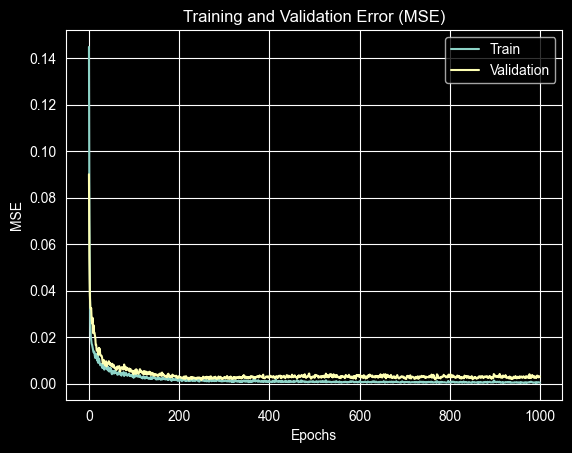

0.0017707362942310284
0.003837795569793343


In [226]:
plt.figure()
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Training and Validation Error (MSE)")
plt.legend()
plt.grid(True)
plt.show()


print(np.mean(train_losses))
print(np.mean(val_losses))

# 5. Test

In [227]:
model.eval()
with torch.no_grad():
    y_hat = model(x_test_t).cpu().numpy().flatten()

y_true = y_test_t.cpu().numpy().flatten()

mae  = mean_absolute_error(y_true, y_hat)
r2   = r2_score(y_true, y_hat)

print(f"MAE:  {mae:.3f} kg/dia")
print(f"R²:   {r2:.3f}")


MAE:  0.019 kg/dia
R²:   0.828


## 5.1. Test evaluation

In [228]:
def classifier_gmd(gmd):
    if gmd < 0.3:
        return "bad"
    else:
        return "average"

y_true_class = [classifier_gmd(v) for v in y_true]
y_hat_class = [classifier_gmd(v) for v in y_hat]

## 5.2. Confusion matrix

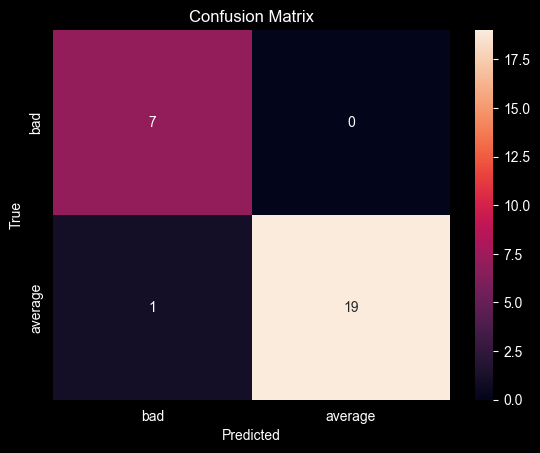

In [229]:
labels = ["bad", "average"]
cm = confusion_matrix(y_true_class, y_hat_class, labels=labels)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=labels,
    yticklabels=labels,
)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [230]:
print(classification_report(
    y_true_class,
    y_hat_class,
    target_names=labels,
    zero_division=0,
))

              precision    recall  f1-score   support

         bad       1.00      0.95      0.97        20
     average       0.88      1.00      0.93         7

    accuracy                           0.96        27
   macro avg       0.94      0.97      0.95        27
weighted avg       0.97      0.96      0.96        27



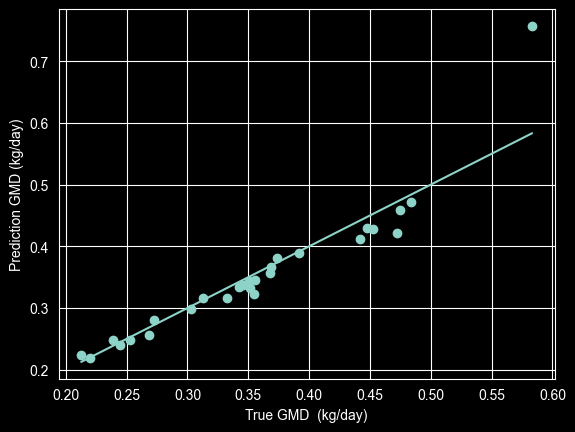

In [231]:
plt.figure()
plt.scatter(y_true, y_hat)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()])
plt.xlabel("True GMD  (kg/day)")
plt.ylabel("Prediction GMD (kg/day)")
plt.grid(True)
plt.show()